In [1]:
from typing import Callable, Tuple, Sequence
from random import uniform
from pyvolution.types.individual import Individual
from pyvolution.models.algebra import show_expression, create_function_from_expression
from pyvolution.models.algebra.basic import (
    create_basic_model, create_default_mutator, show_expression, BasicAlgebraJSONEncoder
)
from pyvolution.visualisation.algebra import create_1d_function_visualisation
from pandas import DataFrame
from numpy import nanpercentile, nanmax, isfinite, arange
from functools import partial
from matplotlib.pyplot import plot, close, figure, subplots
from numpy import arange

## Create fitness function

In order to use pyvolution to solve an algebraic issue we must first create a fitness function that pyvolution will try to adapt to. This is usually a set of points, with the last index value being the function value of the unknown function to be found. 
So (3,4,1) translates to f(3,4)=1
For the sake of simplicity we will stick to two/three dimensional points, meaning functions in R.

In [2]:
def fitness(x: float) -> float:
    return x**2 +2*x + 1

def create_point_set(
    func: Callable[[float], float],
    amount: int=100,
    start: float=-10,
    end: float=10
) -> Sequence[Tuple[float, float]]:
    return tuple(
        (x, func(x)) for x in (i*(end-start)/amount+start for i in range(amount)) 
    )


We will then create a related point set for our function. The more points the better the adaption might be, but keep in
mind that it will also takes a larger amount of time for the computation to finish.

In [3]:
fitness_set = create_point_set(fitness)

## Create evolution strategy

Next we will have to create the evolution strategy using an algebraic model. This is basically done by specifying the population size and a mutator for gene mutation in the offspring. 
There are other parameters as well, but for now we stick to the default values.

In [4]:
mutator = create_default_mutator(0.2, 0.3)
popsize=100
population, evolution, to_expression = create_basic_model(fitness_set, popsize=popsize)

The default mutator takes two propabilities as arguments, the first being the propability that the type of a genome (value, function, etc.) changes. The second being the propability that the shape of the genome changes (its value, its actual function, etc.)

In [5]:
def evolve_until(threshold: float=-10, steps: int=500, min_steps: int=100) -> Sequence[Sequence[Tuple[Individual, float]]]:
    populations = list()
    individuals = population
    for i in range(steps):
        next_generation = tuple(evolution(individuals, i, 1, mutator))
        populations.append(next_generation)
        individuals, scores = zip(*next_generation)
        if max(scores) >= threshold and i > min_steps:
            break
    return populations

In [6]:
result = evolve_until()

In [7]:
best_individuals, scores = zip(*(
       max(generation, key=lambda x: x[1]) for generation in result
))

best_inividuals = list(best_individuals)

evolution_data_best = DataFrame.from_dict(
    dict(
        expression = [show_expression(to_expression(i)) for i in best_individuals],
        func = [to_expression(i) for i in best_individuals],
        score = scores
    )
)

evolution_data_all = DataFrame(
    [
        dict(
            expression=show_expression(to_expression(i)),
            name=i.name,
            generation=i.generation,
            score=score,
            karyogram=i.karyogram
        )
        for generation in result
        for (i, score) in generation
    ]
)

In [8]:
evolution_data_best.sort_values(by='score', inplace=True, ascending=False)
evolution_data_best.head()


,expression,func,score
250,"mul(sub(x,-2.019975462714472),x)","(Function(evaluation=<built-in function mul>, ...",-10.086121
329,"mul(sub(x,-2.019975462714472),x)","(Function(evaluation=<built-in function mul>, ...",-10.086121
342,"mul(sub(x,-2.019975462714472),x)","(Function(evaluation=<built-in function mul>, ...",-10.086121
341,"mul(sub(x,-2.019975462714472),x)","(Function(evaluation=<built-in function mul>, ...",-10.086121
340,"mul(sub(x,-2.019975462714472),x)","(Function(evaluation=<built-in function mul>, ...",-10.086121


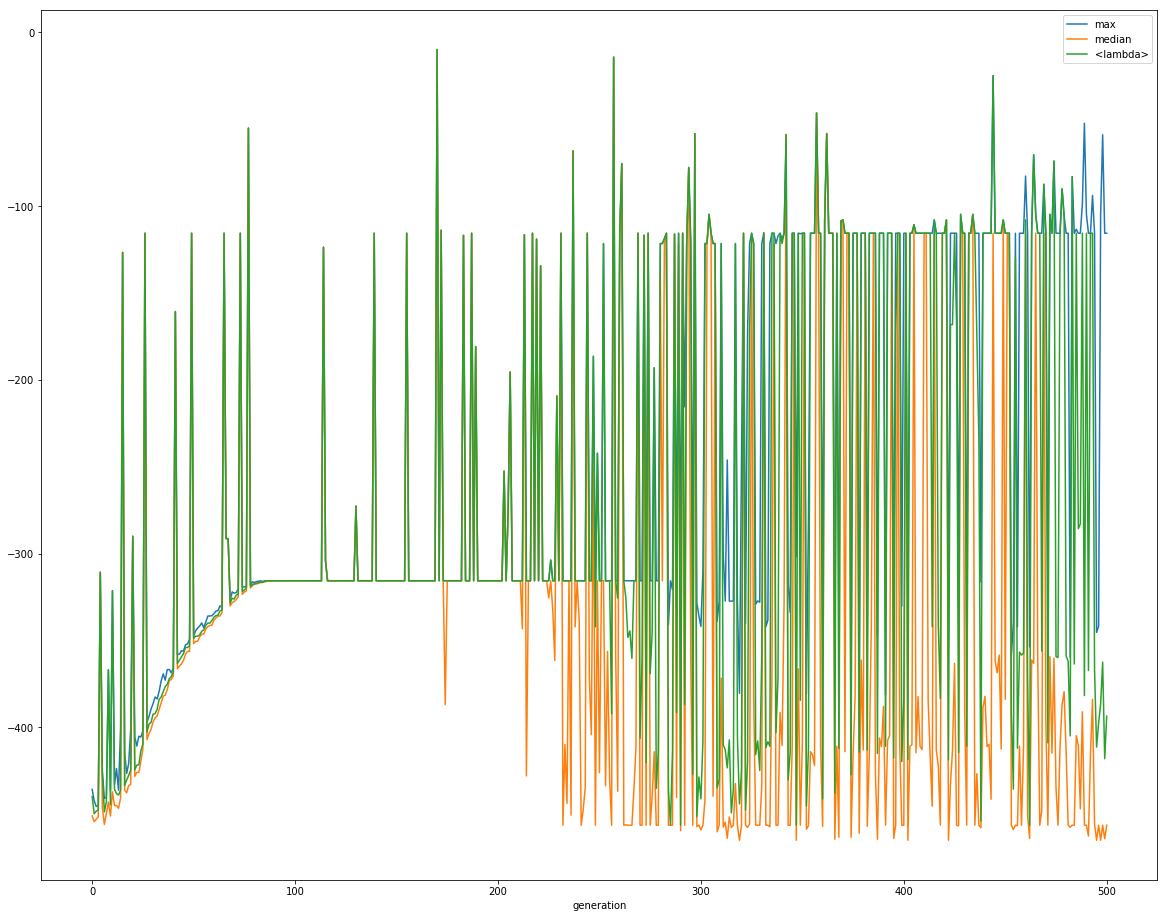

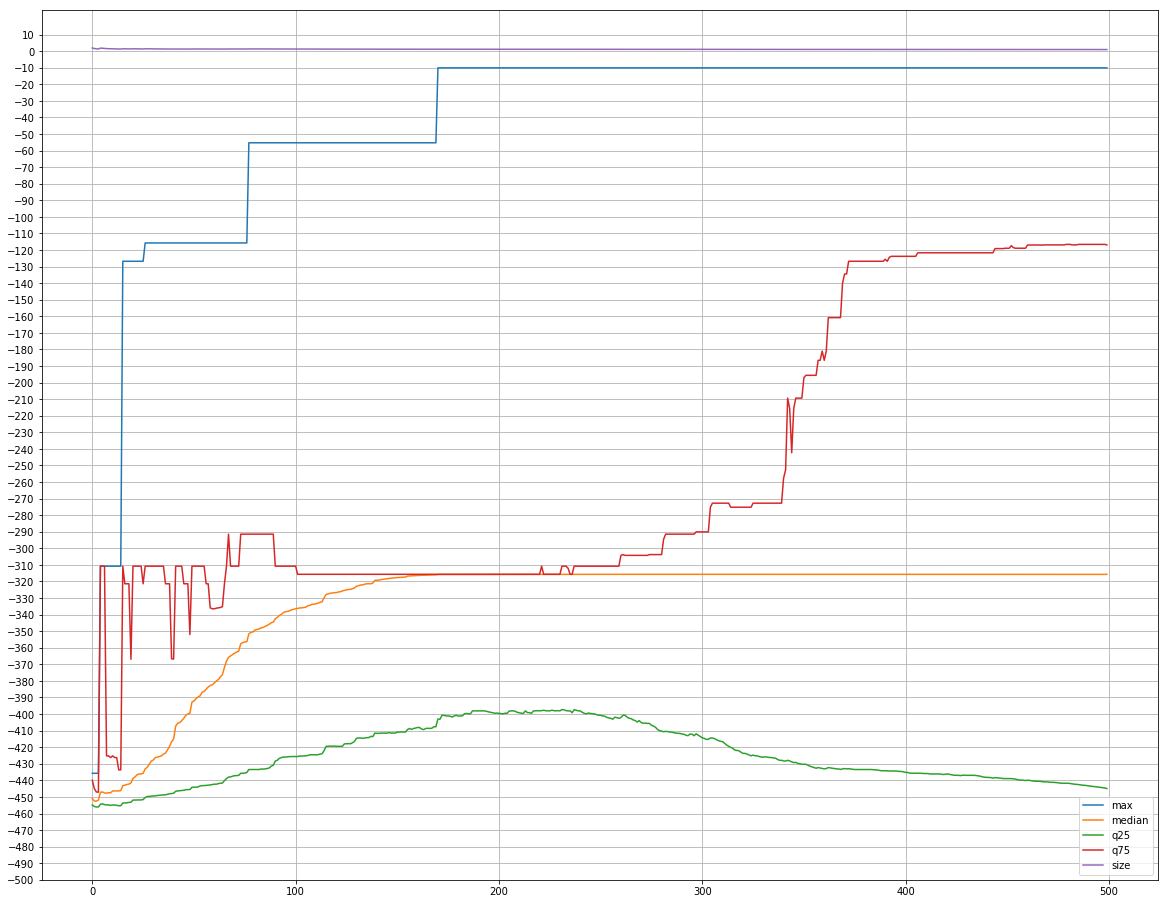

In [9]:
scoresheet = evolution_data_all.groupby(['generation']).agg(
    ['max', 'median', lambda x: x.quantile(0.75)]
)['score']



data = []
def q25(x): return x.quantile(0.25)

for i in range(len(result)):

    selection = evolution_data_all.loc[
        (evolution_data_all['generation'] <= i) & (isfinite(evolution_data_all['score']))
    ]
    stats = selection.agg(
        ['max', 'median', lambda x: x.quantile(0.75), q25]
    )
    data.append(
        dict(
            max=stats['score'][0],
            median=stats['score'][1],
            q75=stats['score'][2],
            q25=stats['score'][3],
            size=len(selection)/((i+1)*popsize)
        )
    )

cumulative = DataFrame(data)
min_score = evolution_data_all[evolution_data_all['score'] > -float('infinity')]['score'].min()

scoresheet.plot(figsize=(20, 16))


cumulative.plot(
    figsize=(20, 16), grid=True, 
    yticks=arange(max(min_score, -500), 20, step=10)
)





mul(sub(x,-2.019975462714472),x)


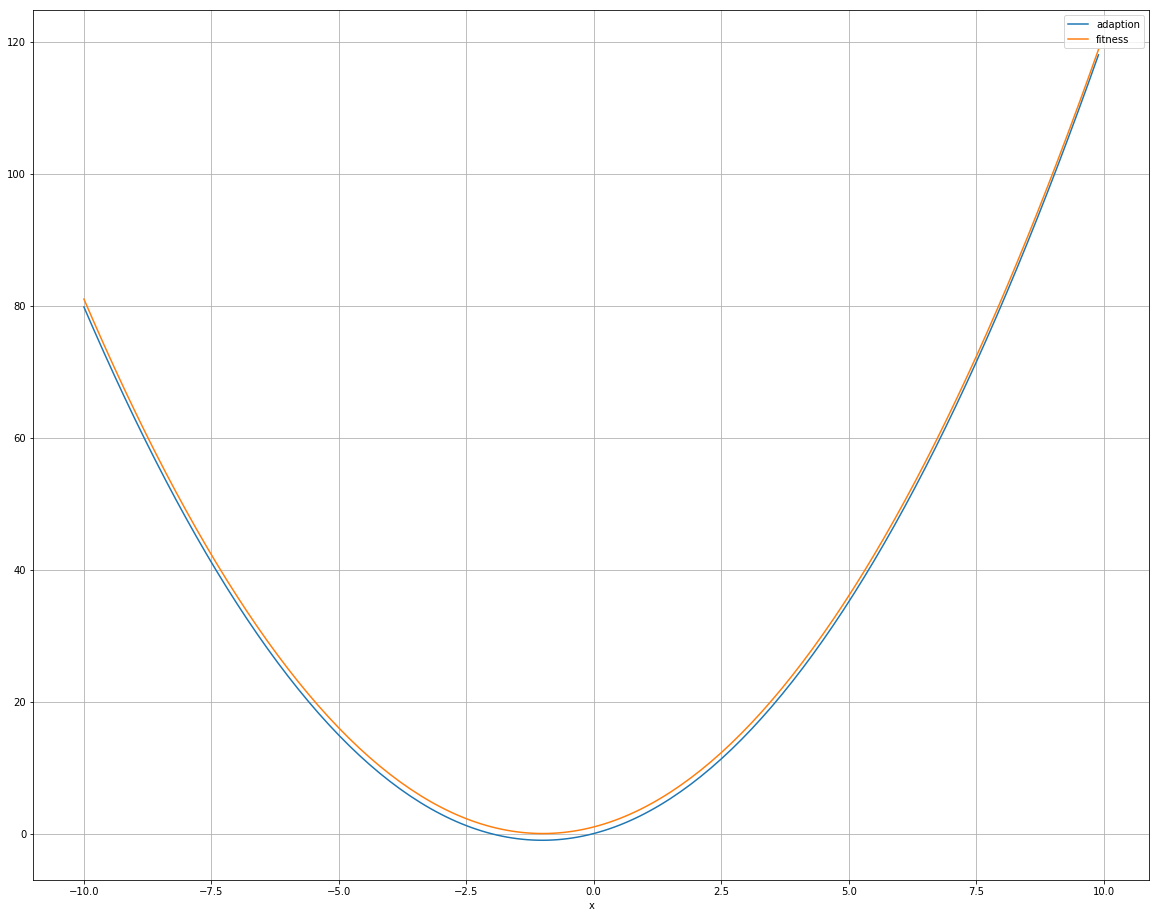

In [10]:
from pyvolution.models.algebra import evaluate
best_id = evolution_data_best['score'].idxmax()
best_adaption = evolution_data_best['func'][best_id]
expression = evolution_data_best['expression'][best_id]

print(expression)

comparison = DataFrame(
    [
        dict(
            x=i,
            fitness=fitness(i),
            adaption=evaluate(best_adaption, dict(x=i), 0.0, -float('infinity'))
        )
        for i in arange(-10, 10, step=0.1)
    ]
)

comparison.plot('x', grid=True, figsize=(20, 16))

In [11]:
animate = create_1d_function_visualisation(['x'], to_expression, yrange=(0.0, 120))

/home/patrick/Documents/Development/pyvolution/pyvolution/models/algebra/__init__.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return func.evaluation(*(evaluate(arg, variables, zero) for arg in args))


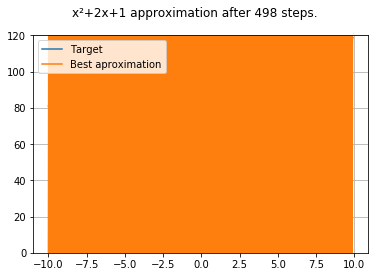

In [17]:
fig, ax = subplots()
title = 'x²+2x+1 approximation after {0} steps.'
fig.suptitle(title)
name = 'Best aproximation'
ax.set_ylim((0.0,120.0))
ax.grid()
xs = arange(-10, 10, step=0.1)
line, = ax.plot(xs, [fitness(x) for x in xs], label='Target')
frames = len(best_individuals)-1
anim = animate(fig, ax, xs, iter(best_individuals), title, name, frames=frames, interval=200, blit=False)
ax.legend()
anim.save('algebra.gif', dpi=100, writer='imagemagick')